In [1]:
%matplotlib inline

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [3]:
def get_mean_and_std(dataset):
    '''Compute the mean and std value of dataset.'''
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, num_workers=2)

    mean = torch.zeros(3)
    std = torch.zeros(3)
    print('==> Computing mean and std..')
    for inputs, targets in dataloader:
        for i in range(3):
            mean[i] += inputs[:, i, :, :].mean()
            std[i] += inputs[:, i, :, :].std()
    mean.div_(len(dataset))
    std.div_(len(dataset))
    return mean, std

In [4]:
#To determine if your system supports CUDA
print("==> Check devices..")
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Current device: ",device)

#Also can print your current GPU id, and the number of GPUs you can use.
print("Our selected device: ", torch.cuda.current_device())
print(torch.cuda.device_count(), " GPUs is available")
#device = 'cpu'

==> Check devices..
Current device:  cuda
Our selected device:  0
1  GPUs is available


In [5]:
print('==> Preparing dataset..')

==> Preparing dataset..


In [6]:
"""1.1"""
img_size, linear_size, fc1_out, fc2_out = 224, 53, 120, 84

calculate_mean_std = False

if calculate_mean_std == True:
    #The transform function for train data
    transform_train = transforms.Compose([
        transforms.Resize(img_size),
        transforms.RandomCrop(img_size, padding=4),
        transforms.ToTensor(),
    ])

    #The transform function for test data
    transform_test = transforms.Compose([
        transforms.Resize(img_size),
        transforms.RandomCrop(img_size, padding=4),
        transforms.ToTensor(),
    ])

    #we will calculate mean and std
    
    trainset = torchvision.datasets.ImageFolder(root='../data/food/train', transform=transform_train)
    testset = torchvision.datasets.ImageFolder(root='../data/food/test', transform=transform_test)
    
    train_mean, train_std = get_mean_and_std(trainset)
    print(train_mean, train_std)
    test_mean, test_std = get_mean_and_std(testset)
    print(test_mean, test_std)
else:
    train_mean, train_std = ([0.5551, 0.4478, 0.3366]), ([0.2337, 0.2414, 0.2386])
    test_mean, test_std = ([0.5607, 0.4518, 0.3425]), ([0.2333, 0.2415, 0.2385])
    

In [7]:
"""1.1+"""
#The transform function for train data
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(train_mean, train_std)
])

#The transform function for test data
transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(test_mean, test_std)
])

In [8]:
"""1.2+"""
trainset = torchvision.datasets.ImageFolder(root='../data/food/train', transform=transform_train)
testset = torchvision.datasets.ImageFolder(root='../data/food/test', transform=transform_test)

In [9]:
"""1.3"""

#Create DataLoader to draw samples from the dataset
#In this case, we define a DataLoader to random sample our dataset. 
#For single sampling, we take one batch of data. Each batch consists 4 images
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=32,
shuffle=False, num_workers=2)

In [10]:
classes = ('Bread', 'DairyProduct', 'Dessert', 'Egg', 'Friedfood',
           'Meat', 'Noodles-Pasta', 'Rice', 'Seafood', 'Soup', 'Vegetable')

In [11]:
print('==> Building model..')

==> Building model..


In [12]:
import torch.nn as nn

In [13]:
# define your own model
class Net(nn.Module):

    #define the layers
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * linear_size * linear_size, fc1_out)
        self.fc2 = nn.Linear(fc1_out, fc2_out)
        self.fc3 = nn.Linear(fc2_out, 11)
        self.relu = nn.ReLU()
        
    #concatenate these layers
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 16 * linear_size * linear_size)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [14]:
#declare a new model
net = Net()
# change all model tensor into cuda type
# something like weight & bias are the tensor 
#net = net.to(device)
print(device)
if device == 'cuda':
    net = net.cuda(0)
else:
    net = net.cpu()

cuda


########################################################################

# 3. Define a Loss function and optimize

########################################################################

In [15]:
print('==> Defining loss function and optimize..')

==> Defining loss function and optimize..


In [16]:
import torch.optim as optim

#loss function
criterion = nn.CrossEntropyLoss()
#optimization algorithm
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-3)

########################################################################

# 4. Train the network

Before training the model, we need to analysis the tensor variable.


Each variable have many attibute, like: .grad_fn, .require_grad, .data, .grad...etc. The ".grad_fn" attribute of "torch.Tensor" is an entry point into the function that has create this "torch.Tensor" variables. Because of ".grad_fn" flag, we can easily create a computing graph in the form of DAG(directed acyclic graph).

And then, the ".require_grad" attribute allows us to determine whether the backward propagation function is going to calculate the gradient of this "torch.Tensor" variable. If one variable has a false value of require_grad, it represent that you don't want to calculate this variable's gradient, and also its gradient will not be updated.

########################################################################

In [17]:
print('==> Training model..')

==> Training model..


In [18]:
#Set the model in training mode
#because some function like: dropout, batchnorm...etc, will have 
#different behaviors in training/evaluation mode
#[document]: https://pytorch.org/docs/stable/nn.html#trchs.nn.Module.train
net.train()
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30,80], gamma=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=5, verbose=True)

In [19]:
for epoch in range(150):  # loop over the dataset multiple times
    #scheduler.step()
    running_loss = 0.0
    correct = 0
    for i, (inputs, labels) in enumerate(trainloader, 0):
        
        #change the type into cuda tensor 
        if device == 'cuda':
            inputs = inputs.cuda(0)
            labels = labels.cuda(0)
        else:
            inputs = inputs.cpu()
            labels = labels.cpu()

        #print(labels)
        #print(inputs)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        # select the class with highest probability
        _, pred = outputs.max(1)
        # if the model predicts the same results as the true
        # label, then the correct counter will plus 1
        correct += pred.eq(labels).sum().item()
        
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
    scheduler.step(100.*correct/len(trainset))
    print('%d epoch, training accuracy: %.2f%%, loss = %.4f' %
          (epoch+1, 100.*correct/len(trainset), running_loss/len(trainset)))
print('Finished Training')

1 epoch, training accuracy: 20.74%, loss = 0.0693
2 epoch, training accuracy: 22.92%, loss = 0.0672
3 epoch, training accuracy: 25.45%, loss = 0.0654
4 epoch, training accuracy: 26.91%, loss = 0.0646
5 epoch, training accuracy: 28.61%, loss = 0.0633
6 epoch, training accuracy: 30.21%, loss = 0.0627
7 epoch, training accuracy: 30.42%, loss = 0.0610
8 epoch, training accuracy: 32.05%, loss = 0.0606
9 epoch, training accuracy: 32.47%, loss = 0.0601
10 epoch, training accuracy: 33.49%, loss = 0.0592
11 epoch, training accuracy: 33.58%, loss = 0.0593
12 epoch, training accuracy: 34.03%, loss = 0.0587
13 epoch, training accuracy: 35.19%, loss = 0.0582
14 epoch, training accuracy: 34.96%, loss = 0.0579
15 epoch, training accuracy: 35.21%, loss = 0.0581
16 epoch, training accuracy: 35.35%, loss = 0.0579
17 epoch, training accuracy: 35.91%, loss = 0.0575
18 epoch, training accuracy: 36.76%, loss = 0.0574
19 epoch, training accuracy: 37.35%, loss = 0.0564
20 epoch, training accuracy: 37.26%, los

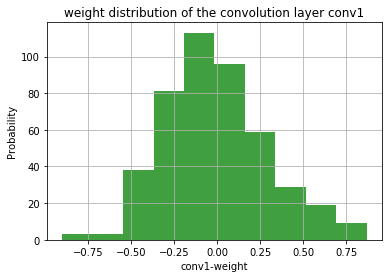

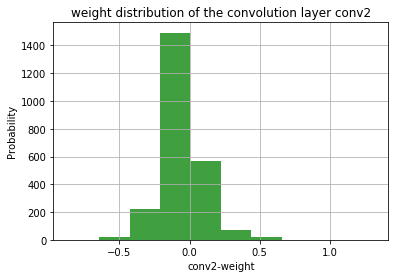

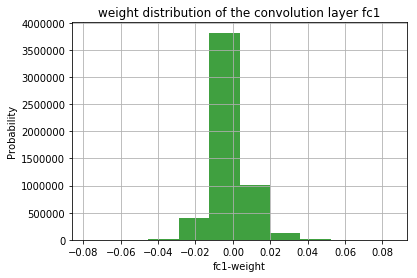

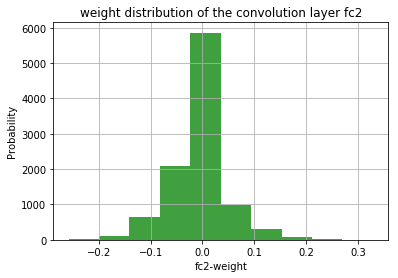

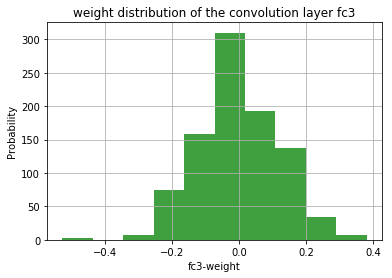

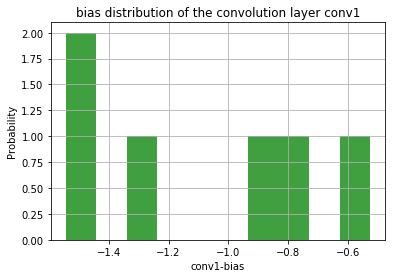

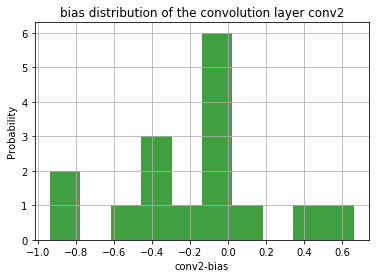

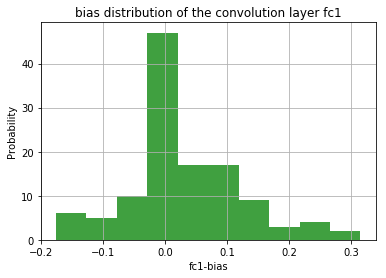

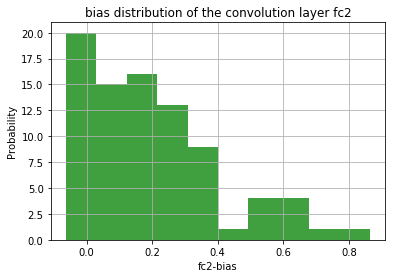

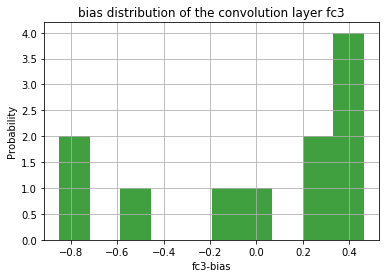

In [20]:
######################
#######LAB 1-1########
"""
To Do Here
        You should show the weight distribution of the convolution layer (conv1, conv2)
        You should show the bias distribution of the convolution layer (conv1, conv2)
        [hint] you can use matplotlib package to show the result in here
"""
######################
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

x = net.conv1.weight.view(-1,1).cpu().detach().numpy()
n, bins, patches = plt.hist(x, facecolor='green', alpha=0.75)

plt.xlabel('conv1-weight')
plt.ylabel('Probability')
plt.title('weight distribution of the convolution layer conv1')

plt.grid(True)
plt.show()

x = net.conv2.weight.view(-1,1).cpu().detach().numpy()
n, bins, patches = plt.hist(x, facecolor='green', alpha=0.75)

plt.xlabel('conv2-weight')
plt.ylabel('Probability')
plt.title('weight distribution of the convolution layer conv2')

plt.grid(True)
plt.show()

x = net.fc1.weight.view(-1,1).cpu().detach().numpy()
n, bins, patches = plt.hist(x, facecolor='green', alpha=0.75)

plt.xlabel('fc1-weight')
plt.ylabel('Probability')
plt.title('weight distribution of the convolution layer fc1')

plt.grid(True)
plt.show()

x = net.fc2.weight.view(-1,1).cpu().detach().numpy()
n, bins, patches = plt.hist(x, facecolor='green', alpha=0.75)

plt.xlabel('fc2-weight')
plt.ylabel('Probability')
plt.title('weight distribution of the convolution layer fc2')

plt.grid(True)
plt.show()

x = net.fc3.weight.view(-1,1).cpu().detach().numpy()
n, bins, patches = plt.hist(x, facecolor='green', alpha=0.75)

plt.xlabel('fc3-weight')
plt.ylabel('Probability')
plt.title('weight distribution of the convolution layer fc3')

plt.grid(True)
plt.show()

x = net.conv1.bias.view(-1,1).cpu().detach().numpy()
n, bins, patches = plt.hist(x, facecolor='green', alpha=0.75)

plt.xlabel('conv1-bias')
plt.ylabel('Probability')
plt.title('bias distribution of the convolution layer conv1')

plt.grid(True)
plt.show()

x = net.conv2.bias.view(-1,1).cpu().detach().numpy()
n, bins, patches = plt.hist(x, facecolor='green', alpha=0.75)

plt.xlabel('conv2-bias')
plt.ylabel('Probability')
plt.title('bias distribution of the convolution layer conv2')

plt.grid(True)
plt.show()

x = net.fc1.bias.view(-1,1).cpu().detach().numpy()
n, bins, patches = plt.hist(x, facecolor='green', alpha=0.75)

plt.xlabel('fc1-bias')
plt.ylabel('Probability')
plt.title('bias distribution of the convolution layer fc1')

plt.grid(True)
plt.show()

x = net.fc2.bias.view(-1,1).cpu().detach().numpy()
n, bins, patches = plt.hist(x, facecolor='green', alpha=0.75)

plt.xlabel('fc2-bias')
plt.ylabel('Probability')
plt.title('bias distribution of the convolution layer fc2')

plt.grid(True)
plt.show()

x = net.fc3.bias.view(-1,1).cpu().detach().numpy()
n, bins, patches = plt.hist(x, facecolor='green', alpha=0.75)

plt.xlabel('fc3-bias')
plt.ylabel('Probability')
plt.title('bias distribution of the convolution layer fc3')

plt.grid(True)
plt.show()

In [22]:
#After training , save the model first
#You can saves only the model parameters or entire model
#Some difference between the two is that entire model 
#not only include parameters but also record hwo each 
#layer is connected(forward method).
#[document]: https://pytorch.org/docs/master/notes/serialization.html

print('==> Saving model..')

#only save model parameters
torch.save(net.state_dict(), './lab1-3v4_checkpoint.t7')
#you also can store some log information
state = {
    'net': net.state_dict(),
    'acc': 100.*correct/len(trainset),
    'epoch': 75
}
torch.save(state, './lab1-3v4_checkpoint.t7')

#save entire model
torch.save(net, './lab1-3v4_model.pt')

print('Finished Saving')

==> Saving model..
Finished Saving


/root/anaconda3/lib/python3.7/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


########################################################################

# 5. Test the network on the test data

########################################################################

In [23]:
#Before testing, we can load the saved model
#Depend on how you save your model, need 
#different way to use it

print('==> Loading model..')

#If you just save the model parameters, you
#need to redefine the model architecture, and
#load the parameters into your model
net = Net()
checkpoint = torch.load('./lab1-3v4_checkpoint.t7')
net.load_state_dict(checkpoint['net'])

#If you save the entire model
net = torch.load('./lab1-3v4_model.pt')

print('Finished Loading')

==> Loading model..
Finished Loading


In [24]:
print('==> Testing model..')

#Set the model in evaluation mode
#[document]: https://pytorch.org/docs/stable/nn.html#torch.nn.Module.eval 
net.eval()


==> Testing model..


Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=44944, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=11, bias=True)
  (relu): ReLU()
)

In [25]:
######################
#######LAB 1-1########
"""
To Do Here

        You should complete the testing step in LAB 1-1
You should show the total accuracy & loss [10000 cifar10 test cases]
  You also need to tell us, how about the accuracy for each class
 
    For example: Total accuracy is: 60.0% and loss is: 0.02  
                 For each class in cifar 10:
                 Accuracy of plane : 58.0%
                 Accuracy of   car : 22.4%
                            .
                            .
                            .
"""
######################
correct = 0
total = 0
running_loss = 0.0

class_correct = list(0. for i in range(11))
class_total = list(0. for i in range(11))

with torch.no_grad():
    test_run = 0
    for data in testloader:
        images, labels = data

        if device == 'cuda':
            images = images.cuda(0)
            labels = labels.cuda(0)
        else:
            images = images.cpu()
            labels = labels.cpu()
        
        #print(test_run, " ", end="")
        #test_run = test_run + labels.size(0)
        
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        loss = criterion(outputs, labels)
        running_loss += loss.item()

        c = (predicted == labels).squeeze()
        #print(predicted)
        #print(labels.size(0))
        #print("(", c, "), ")
        for i in range(labels.size(0)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

print('Accuracy of the network on the %d test images: %d%%, and loss is: %.3f'
      % (total, 100 * correct / total, running_loss / total))

for i in range(11):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of the network on the 3347 test images: 60%, and loss is: 0.035
Accuracy of Bread : 39 %
Accuracy of DairyProduct : 25 %
Accuracy of Dessert : 90 %
Accuracy of   Egg : 49 %
Accuracy of Friedfood : 55 %
Accuracy of  Meat : 60 %
Accuracy of Noodles-Pasta : 67 %
Accuracy of  Rice : 65 %
Accuracy of Seafood : 56 %
Accuracy of  Soup : 64 %
Accuracy of Vegetable : 79 %


In [37]:
import os
import sys
import re
from collections import OrderedDict

def train_acc_loss_result(fname):

    dictionary_acc = OrderedDict()
    dictionary_best = OrderedDict()
    dictionary_loss = OrderedDict()
    dictionary_lr = OrderedDict()
    
    with open(fname) as fp:  
        best = 0
        
        for cnt, line in enumerate(fp):
            # print("Line {}: {}".format(cnt, line))
            # 199 Epoch val Loss: 0.0798 Acc: 0.8258
            pattern = re.compile(r"(\d+) Epoch val Loss: (\d+.\d+) Acc: (\d+.\d+)")
            match = pattern.match(line)
            if match:
                epoch_str, loss_str, acc_str = match.groups()
                print('Validation --- Epoch: {:s}, loss: {:s}, acc: {:s}'.
                      format(epoch_str, loss_str, acc_str))

                Epoch = int(epoch_str)
                loss = float("{:f}".format(float(loss_str)))
                acc = float("{:f}".format(float(acc_str)))
                
                if(best < acc):
                    best = acc
                    
                dictionary_best[Epoch] = best
                
            # 78 epoch, training accuracy: 46.31%, loss = 0.0486
            pattern = re.compile(r"(\d+) epoch, training accuracy: (\d+.\d+)%, loss = (\d+.\d+)")
            match = pattern.match(line)
            if match:
                epoch_str, acc_str, loss_str = match.groups()
                print('Training --- Epoch: {:s}, loss: {:s}, acc: {:s}'.
                      format(epoch_str, acc_str, loss_str))

                Epoch = int(epoch_str)
                acc = float("{:f}".format(float(acc_str)))
                loss = float("{:f}".format(float(loss_str)))
                
                dictionary_acc[Epoch] = acc
                dictionary_loss[Epoch] = loss

            # Epoch    77: reducing learning rate of group 0 to 1.0000e-03.
            # Epoch   117: reducing learning rate of group 0 to 1.0000e-04.
            pattern = re.compile(r"Epoch(\s+)(\d+): reducing learning rate of group 0 to (\d+.\d+e-\d+).")
            match = pattern.match(line)
            if match:
                space_str, epoch_str, lr_str = match.groups()
                print('Learning Rate --- Epoch: {:s}, lr: {:s}'.
                      format(epoch_str, lr_str))

                Epoch = int(epoch_str)
                lr = float("{0:.10f}".format(float(lr_str)))
                
                dictionary_lr[Epoch] = lr
                
    return dictionary_acc, dictionary_loss, dictionary_lr

In [38]:
import matplotlib.pyplot as plt
import itertools

def show_train_acc(dictionary_acc, dictionary_loss, dictionary_lr):
    fig, ax1 = plt.subplots()

    fig.set_figheight(20)
    fig.set_figwidth(20)

    ax1.set_title('Training/Validation Accuracy & Loss / Learning Rate', fontsize=20)

    ax2 = ax1.twinx()
    ax2.figure.figsize=(120,120)
    
    l1, = ax1.plot(list(dictionary_acc.keys()), list(dictionary_acc.values()), 'b-')
    l2, = ax2.plot(list(dictionary_loss.keys()), list(dictionary_loss.values()), 'r--')
    l3, = ax2.plot(list(dictionary_lr.keys()), list(dictionary_lr.values()), 'go')
    
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    ax1.tick_params(axis='both', which='major', labelsize=20)
    ax2.tick_params(axis='y', which='major', labelsize=20)

    ax1.set_xlabel('Epoch', fontsize=20)
    ax1.set_ylabel('Accuracy', fontsize=20, color='b')
    ax2.set_ylabel('Loss / rate', fontsize=20, color='r')
    ax2.set_yscale("log", nonposy='clip')

    #ax1.set(ylim=[0, 100])
    #ax2.set(ylim=[0, 0.2])
    
    ax1.grid(axis='both', which='both')
    plt.legend(handles=[l1, l2, l3],
               labels=['Train Accuracy', 'Loss', 'learning rate'], fontsize=20, loc='right')

    plt.show()

In [39]:
fname = './lab1-3 v4.log'
dictionary_acc, dictionary_loss, dictionary_lr = train_acc_loss_result(fname)

Training --- Epoch: 1, loss: 20.74, acc: 0.0693
Training --- Epoch: 2, loss: 22.92, acc: 0.0672
Training --- Epoch: 3, loss: 25.45, acc: 0.0654
Training --- Epoch: 4, loss: 26.91, acc: 0.0646
Training --- Epoch: 5, loss: 28.61, acc: 0.0633
Training --- Epoch: 6, loss: 30.21, acc: 0.0627
Training --- Epoch: 7, loss: 30.42, acc: 0.0610
Training --- Epoch: 8, loss: 32.05, acc: 0.0606
Training --- Epoch: 9, loss: 32.47, acc: 0.0601
Training --- Epoch: 10, loss: 33.49, acc: 0.0592
Training --- Epoch: 11, loss: 33.58, acc: 0.0593
Training --- Epoch: 12, loss: 34.03, acc: 0.0587
Training --- Epoch: 13, loss: 35.19, acc: 0.0582
Training --- Epoch: 14, loss: 34.96, acc: 0.0579
Training --- Epoch: 15, loss: 35.21, acc: 0.0581
Training --- Epoch: 16, loss: 35.35, acc: 0.0579
Training --- Epoch: 17, loss: 35.91, acc: 0.0575
Training --- Epoch: 18, loss: 36.76, acc: 0.0574
Training --- Epoch: 19, loss: 37.35, acc: 0.0564
Training --- Epoch: 20, loss: 37.26, acc: 0.0559
Training --- Epoch: 21, loss:

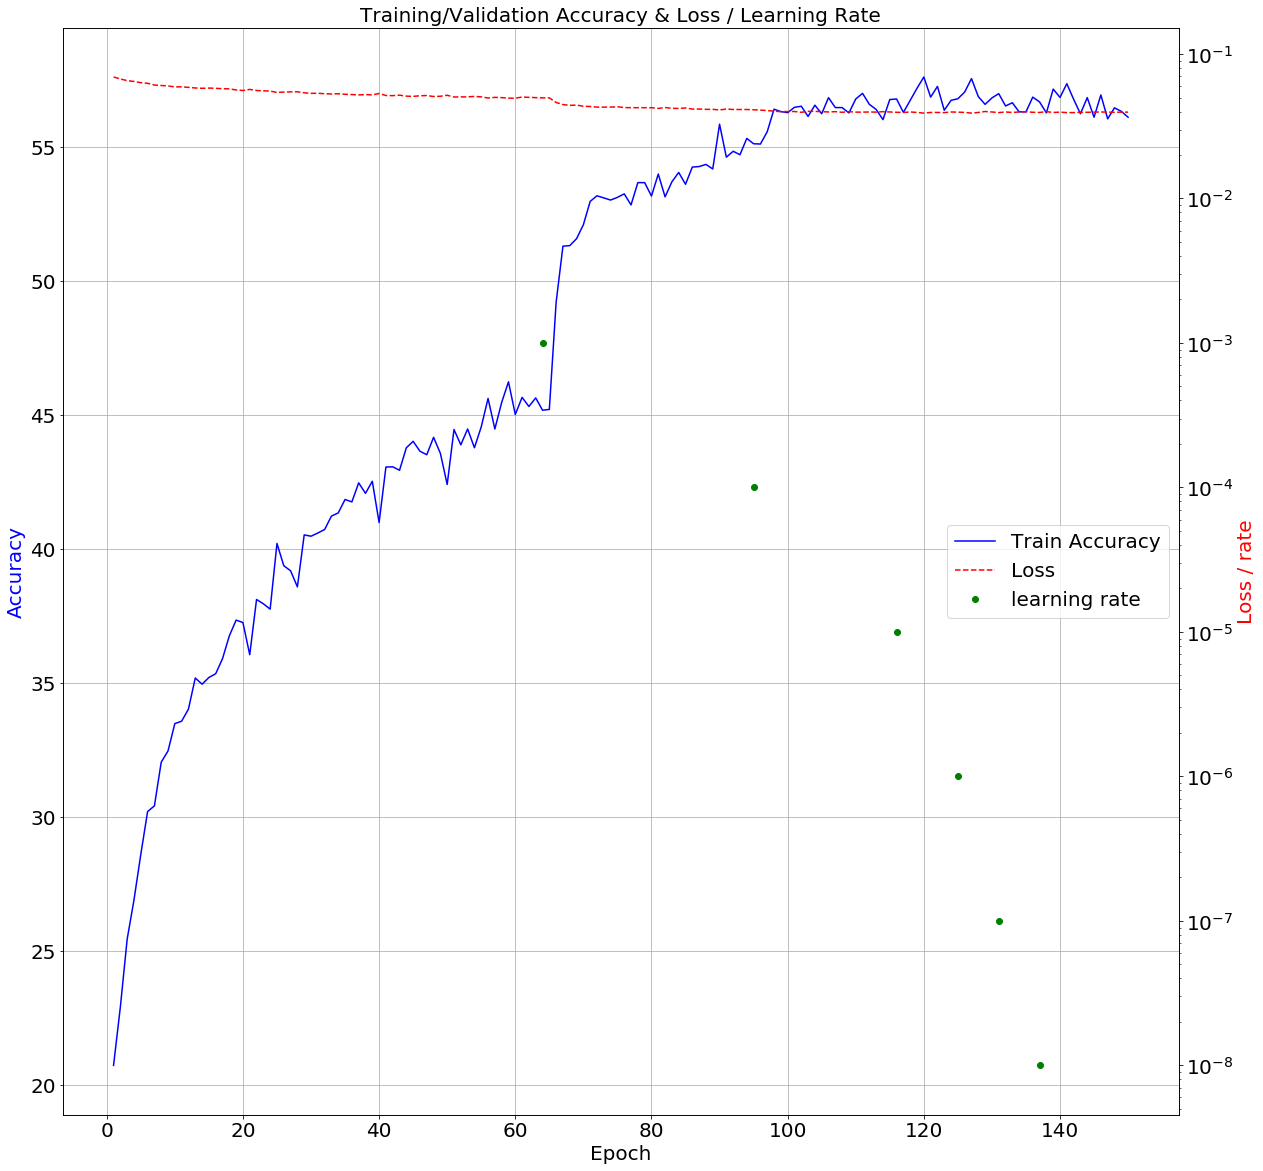

In [40]:
show_train_acc(dictionary_acc, dictionary_loss, dictionary_lr)